# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [152]:
# import libraries here; add more as necessary
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# magic word for producing visualizations in notebook
%matplotlib inline


from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
#import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

In [2]:
from sklearn.preprocessing import Imputer

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
def load_input_data(loaded=False):
    """
    Initialize input data 
    
    Returns:
        azdias           : Azdias dataframe
        customers        : Customers dataframe
        attribute_values : Attribute values dataframe
        attribute_info   : Attribute info dataframe
    """
    if(loaded):
        azdias = pd.read_csv('/home/workspace/data/Azdias_cleaned.csv')
        customers = pd.read_csv('/home/workspace/data/Customers_cleaned.csv')
        attribute_values = pd.read_excel('/home/workspace/DIAS Attributes - Values 2017.xlsx',header=1)
        attribute_info = pd.read_excel('/home/workspace/DIAS Information Levels - Attributes 2017.xlsx',header=1)
    else:
        azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
        customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
        attribute_values = pd.read_excel('/home/workspace/DIAS Attributes - Values 2017.xlsx',header=1)
        attribute_info = pd.read_excel('/home/workspace/DIAS Information Levels - Attributes 2017.xlsx',header=1)
    return azdias,customers,attribute_values,attribute_info



In [4]:
azdias, customers, attribute_values, attribute_info = load_input_data(False)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Data Pre-processing

### 1. Verify data size : 
Verify whether the shapes of dataframes are as described

In [5]:
print("Azdias shape -",azdias.shape)
print("Customers shape -",customers.shape)

Azdias shape - (891221, 366)
Customers shape - (191652, 369)


In [6]:
Different_cols = [col for col in customers.columns if col not in azdias.columns]
print("Additional columns in Customers Data - ",Different_cols)

Additional columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


Thus, the shapes match with the description

Next, we print heads of each dataset to check them

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In both these tables, there are a lot of null values. We can instead look at the additional columns present in the customers dataframe

In [9]:
customers[Different_cols].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


These columns consist of significant information of the customers and their buying preference.

Since we have two dataframes containing metadata about these columns, we explore those files below

In [10]:
attribute_values.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,NaN,NaN,1,< 30 years
NaN,NaN,NaN,2,30 - 45 years
NaN,NaN,NaN,3,46 - 60 years
NaN,NaN,NaN,4,> 60 years


As observed above, the same attribute has multiple rows, representing different values the attribute can hold. Since the attribute column is NaN for all rows except 1, we can auto fill the column with the pandas fill method

In [11]:
attribute_values["Attribute"] = attribute_values["Attribute"].ffill()
attribute_values.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,AGER_TYP,NaN,1,passive elderly
NaN,AGER_TYP,NaN,2,cultural elderly
NaN,AGER_TYP,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
NaN,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
NaN,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
NaN,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [12]:
attribute_info.head()

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


### 2. Handling Warning

As prompted above while loading the data, datatypes of the columns 18 and 19 for dataframe azdias consistent of a warning. We can resolve the warning 

In [72]:
print(azdias.columns[18:20])

issue_cols = list(azdias.columns[18:20])

Index(['CJT_TYP_4', 'CJT_TYP_5'], dtype='object')


In [14]:
#Looking at both the columns
attribute_values[attribute_values["Attribute"]=='CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
NaN,CAMEO_DEUG_2015,NaN,1,upper class
NaN,CAMEO_DEUG_2015,NaN,2,upper middleclass
NaN,CAMEO_DEUG_2015,NaN,3,established middleclasse
NaN,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
NaN,CAMEO_DEUG_2015,NaN,5,active middleclass
NaN,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
NaN,CAMEO_DEUG_2015,NaN,7,lower middleclass
NaN,CAMEO_DEUG_2015,NaN,8,working class
NaN,CAMEO_DEUG_2015,NaN,9,urban working class


In [15]:
# Column CAMEO_INTL_2015 is named as CAMEO_DEUINTL_2015 in attribute value file
attribute_values[attribute_values["Attribute"]=='CAMEO_DEUINTL_2015']

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
NaN,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
NaN,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
NaN,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
NaN,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
NaN,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
NaN,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
NaN,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
NaN,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


From the printed values, we can infer that these columns must have values between -1 and 55. We cross check this in the azdias and customers file

In [16]:
azdias[issue_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [17]:
azdias[issue_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

In [18]:
customers[issue_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [19]:
customers[issue_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'], dtype=object)

The columns contain values such as 'X' and 'XX' and  which are inappropriate for an integer data column. Thus we need to fix these rows.

In [79]:
def resolve_issue_cols(df):
    """
    Function to replace 'X' and 'XX' with nan values  in the issue columns
    """
    print("reached")
    df[issue_cols] = df[issue_cols].replace({"X":np.nan,"XX":np.nan})
    df[issue_cols] = df[issue_cols].astype(float)
    
    return df

In [21]:
#Resolve customers and azdias
customers = resolve_issue_cols(customers)
azdias = resolve_issue_cols(azdias)

Confirming whether the values are replaced:

In [22]:
customers[issue_cols[0]].unique()

array([  1.,  nan,   5.,   4.,   7.,   3.,   9.,   2.,   6.,   8.])

In [23]:
customers[issue_cols[1]].unique()

array([ 13.,  nan,  34.,  24.,  41.,  23.,  15.,  55.,  14.,  22.,  43.,
        51.,  33.,  25.,  44.,  54.,  32.,  12.,  35.,  31.,  45.,  52.])

In [24]:
azdias[issue_cols[0]].unique()

array([ nan,   8.,   4.,   2.,   6.,   1.,   9.,   5.,   7.,   3.])

In [25]:
azdias[issue_cols[1]].unique()

array([ nan,  51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,
        41.,  34.,  55.,  25.,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

Thus we have replaced the values 'X' and 'XX' in the dataset 

### 3. Attribute Values Exploration

We now look at the attribute values that describe the dataframes.

In [26]:
attribute_values.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,AGER_TYP,NaN,1,passive elderly
NaN,AGER_TYP,NaN,2,cultural elderly
NaN,AGER_TYP,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
NaN,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
NaN,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
NaN,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [27]:
#We can simply remove the rows with Nan to analyze the data better

attribute_values.dropna()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
NaN,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
NaN,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
NaN,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
NaN,BALLRAUM,distance to next urban centre,-1,unknown
NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


Inference : All features do not contain unkown values. This means such fields are mandatory. We can further replace the unkown values with Nan

### 4. Data Profiling and Feature Extraction

Since we have gone through the data and fixed the glaring issues, we can now proceed with the data cleaning. Simultaneously, we can carry out the feature extraction process. This can be done by splitting the columns with multiple information into multiple columns. We begin with LP_ columns

In [28]:
print(azdias.LP_FAMILIE_FEIN.unique())
print(azdias.LP_FAMILIE_GROB.unique())
print(azdias.LP_STATUS_GROB.unique())
print(azdias.LP_LEBENSPHASE_GROB.unique())
print(azdias.LP_LEBENSPHASE_FEIN.unique())
print(azdias.LP_STATUS_FEIN.unique())

[  2.   5.   1.   0.  10.   7.  11.   3.   8.   4.   6.  nan   9.]
[  2.   3.   1.   0.   5.   4.  nan]
[  1.   2.   4.   5.   3.  nan]
[  4.   6.   1.   0.  10.   2.   3.   5.   7.  12.  11.   9.   8.  nan]
[ 15.  21.   3.   0.  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.
  11.  25.  13.   7.  18.  31.  19.  38.  35.  30.  22.  14.  33.  29.  24.
  28.  37.  26.  39.  27.  36.   9.  34.  nan  40.  16.  17.]
[  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]


As observed these columns contain a value '0' which does not correspond to any category in the attribute values dataset. Thus we can replace 0 with NaN values. Furthermore, LP_FAMILIE_FEIN and LP_STATUS_FEIN give a classification of the family type and status. Similar information is contained in the columns LP_FAMILIE_GROB and LP_STATUS_GROB. THus, we can drop the earlier columns for further analysis.

In [65]:
def resolve_LP_cols(df):
    """
    Function to replace 0 with NaN in LP columns
    """
    
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    df[cols] = df[cols].replace({0:np.nan})
    df[cols] = df[cols].astype(float)
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [30]:
customers = resolve_LP_cols(customers)
azdias =resolve_LP_cols(azdias)

In [31]:
print(azdias.LP_FAMILIE_FEIN.unique())
print(azdias.LP_FAMILIE_GROB.unique())
print(azdias.LP_STATUS_GROB.unique())
print(azdias.LP_LEBENSPHASE_GROB.unique())
print(azdias.LP_LEBENSPHASE_FEIN.unique())
print(azdias.LP_STATUS_FEIN.unique())

[  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
[  1.   2.   0.  nan]
[  0.   1.  nan]
[  1.   2.  nan   3.   4.]
[  3.   2.   1.  nan   4.]
[  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]


Now, we address the issue of unkown values in the data.

In [32]:
unknown_attribute_values = attribute_values[attribute_values["Meaning"] == "unknown"]
print(len(unknown_attribute_values))

232


These values need to be replaced with NaN

In [115]:
def get_unknown(attrib, unknown_attribute_values):
    """Returns the representation of unknown values"""
    
    unknown = unknown_attribute_values[unknown_attribute_values["Attribute"] == attrib]["Value"]
    unknown = unknown.astype(str).str.cat(sep=",")
    unknown = [int(x) for x in unknown.split(",")]
      
    return [unknown]

In [38]:
ager_typ_unknown = get_unknown("AGER_TYP", unknown_attribute_values)

print(ager_typ_unknown)

[[-1]]


In [116]:
def replace_unknown_with_nan(val, unknown):
    """Replaces unknown values with np.nan values if the value mathes with the unknown representation"""
    if val in unknown:
        return np.nan
    else:
        return val

In [40]:
azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(replace_unknown_with_nan, args=(ager_typ_unknown))

In [41]:

azdias.head(15)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,15.0
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,21.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,NaN
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,32.0
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,8.0
6,910248,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2,2.0
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1,5.0
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3,10.0
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3,4.0


Thus all the -1 in AGER_TYP have been replaced by Nan

Similarly, all 232 columns can be replaced with NaN

In [117]:
def replace_unknowns(df, unknown_attribute_values, verbose=False):
    """
    Replaces unknown values to 'np.nan' in all the columns provided in unknown_attribute_values list.
    """
    for attrib in unknown_attribute_values.Attribute:
        unknown = get_unknown(attrib, unknown_attribute_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unknown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unknown_with_nan, args=(unknown))
    return df

In [43]:

azdias = replace_unknowns(azdias, unknown_attribute_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_70
Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Repl

In [44]:
customers = replace_unknowns(customers, unknown_attribute_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIVA

### 5 Missing Information in Dataframes

After removing and replacing all the unknown values, we can look at the missing values.

In [45]:
def identify_missing_values(df):
    """
    Input - Dataframe 
    Output - Dataframe with information about column-wise missing values percentages.
    """
    missing_percent = df.isna().sum() * 100/ len(df)
    
    missing_percent_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percent}).reset_index(drop=True)
    return missing_percent_df

In [46]:
customer_missing_df = identify_missing_values(customers)
azdias_missing_df = identify_missing_values(azdias)

In [47]:
print("Total columns in Customers - ", len(customers.columns))
print("No of columns with missing values in customers - ",
      len(customer_missing_df[customer_missing_df.Missing_Percentage > 0]))

print("Total No of columns in Azdias - ", len(azdias.columns))
print("No of columns with missing values in azdias - ",
      len(azdias_missing_df[azdias_missing_df.Missing_Percentage > 0]))

Total columns in Customers -  370
No of columns with missing values in customers -  280
Total No of columns in Azdias -  367
No of columns with missing values in azdias -  280


In [48]:
def plot_missing_split(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    # fig.tight_layout()
    plt.show()

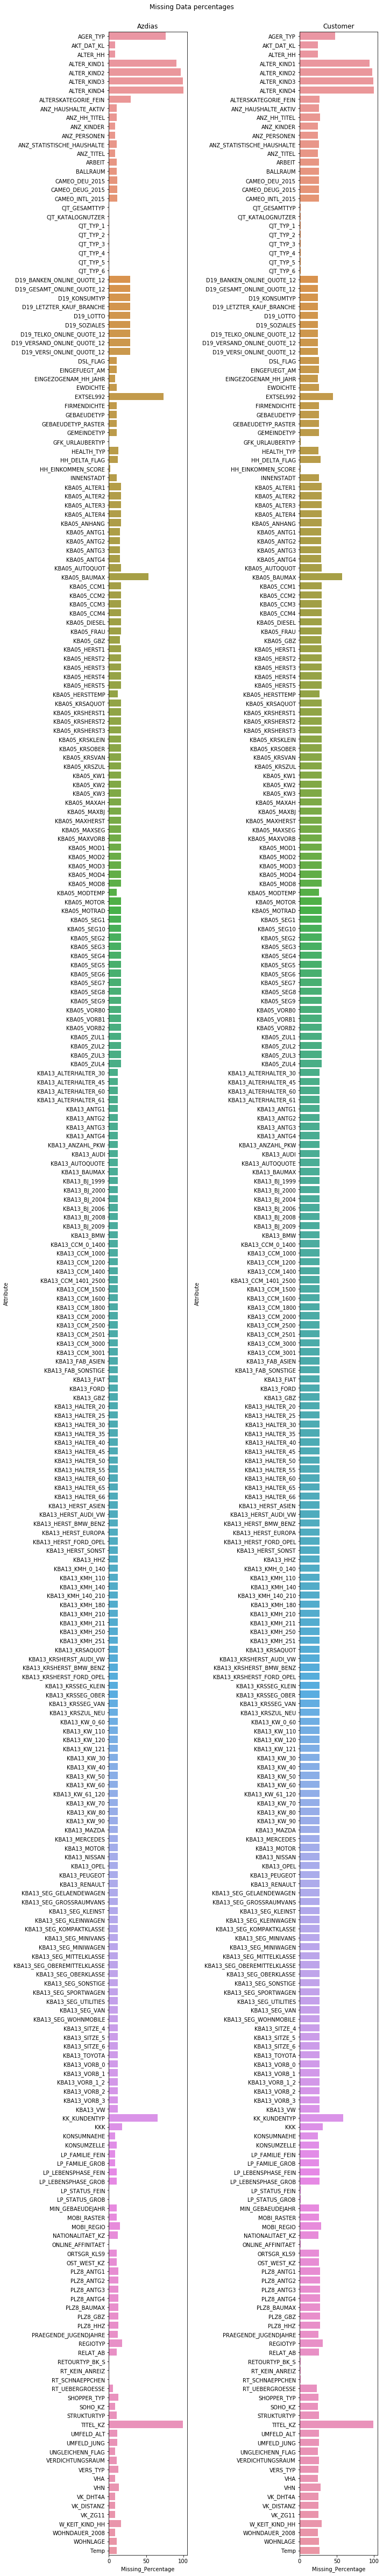

In [49]:
plot_missing_split(azdias_missing_df, customer_missing_df, percentage=0)

Inference:
    Both datasets contain same columns with missing values. Also the percentage of missing values for these columns are almost equal. Thus, possibly customers is a subset of azdias dataset.
    
Since many columns contain missing values, we can set a threshold for filtering columns with missing values.

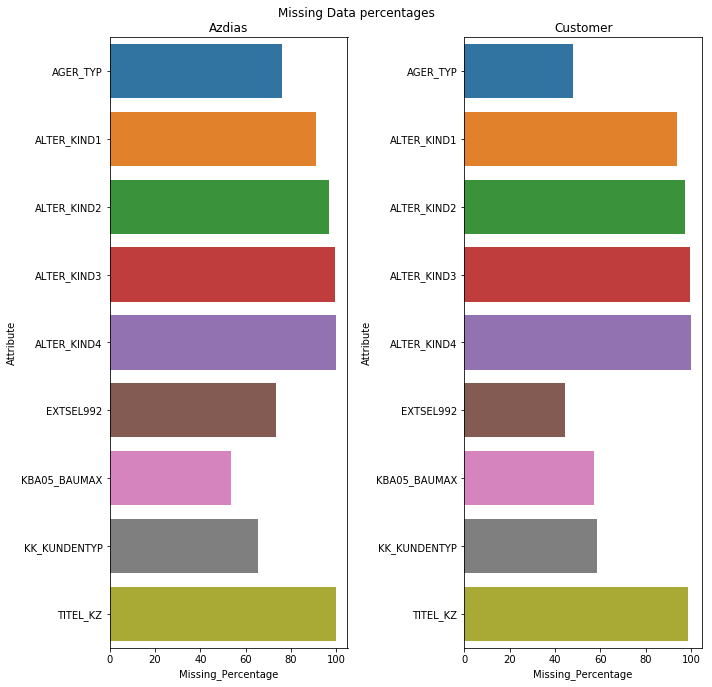

In [50]:
plot_missing_split(azdias_missing_df, customer_missing_df, percentage=40, figsize=(10, 10))

Thus, after setting a threshold of 40%, we have 9 columns in both customers and azdias datasets. We thus drop these columns.

In [67]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [52]:
print("Number of columns Before dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

azdias, customers, removed_cols = remove_missing_columns(azdias, customers, customer_missing_df, azdias_missing_df)

print("Number of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns Before dropping
Azdias - 367
Customers - 370
		Removed 11 columns from given dataframes
Number of columns After dropping
Azdias - 356
Customers - 359


*After looking at columns, we now look at rows with missing values*

In [53]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

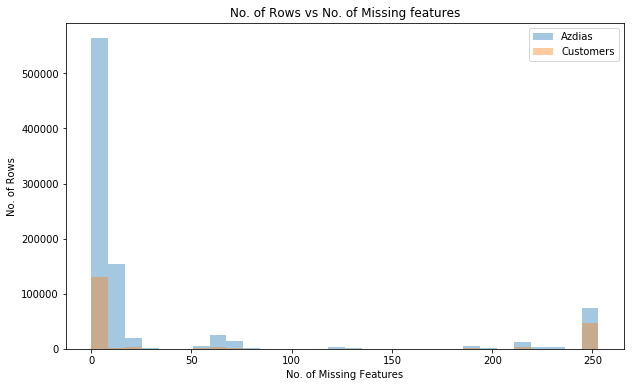

In [54]:
plot_missing_rowwise_histogram(azdias, customers)

Thus, We have 250 features missing in almost 70000 rows in azdias and 50000 rows in customers. We can thus remove these rows.

In [55]:
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [56]:

print("Number of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Number of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Number of rows Before dropping
Azdias - 891221
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 153933 rows from  dataframe
Number of rows After dropping
Azdias - 737288
Customers - 134246


**Column EINGEFUEGT_AM contains date information, thus we convert this column to datetime**

In [107]:
def fix_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [58]:
customers = fix_eigefugt_col(customers)
azdias = fix_eigefugt_col(azdias)

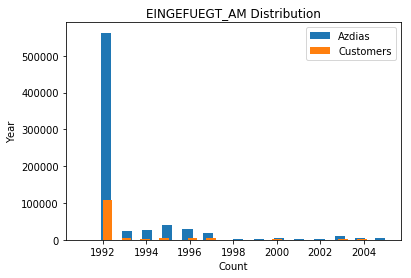

In [59]:
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
plt.ylabel("Year")
plt.xlabel("Count")
plt.title("EINGEFUEGT_AM Distribution")
plt.legend()
plt.show()

### FEATURE ENCODING : 
Since some of the features represent categorical information, we can replace them with integer values for the purpose of standardizing

In [68]:
def feature_encoding(df):
    """
    Function to encode the features "OST_WEST_KZ","ANREDE_KZ","CAMEO_INTL_2015"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    
    #Since column WOHNLAGE contains 0 as default value, we replace it with NaN
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    
    return df

In [61]:
azdias = feature_encoding(azdias)
customers = feature_encoding(customers)

In [13]:
azdias.to_csv('/home/workspace/data/Azdias_cleaned.csv', index=False)
customers.to_csv('/home/workspace/data/Customers_cleaned.csv', index=False)

In [4]:
azdias, customers, attribute_values, attribute_info = load_input_data(True)

### SCALING FEATURES

Before we scale the features, we need to ensure that all missing values have been removed or replaced. In the sections above, we have removed the features with missing values higher than a set threshold. For other features, we need to replace them. This can be done with the sklearn impute method

In [5]:
azdias.info

<bound method DataFrame.info of               LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0        910220.0         9.0       0.0                  21.0   
1        910225.0         9.0      17.0                  17.0   
2        910226.0         1.0      13.0                  13.0   
3        910241.0         1.0      20.0                  14.0   
4        910244.0         1.0      10.0                  10.0   
5        910248.0         9.0       0.0                  15.0   
6        910261.0         1.0      14.0                  14.0   
7        645145.0         9.0      16.0                  16.0   
8        645153.0         5.0      17.0                  17.0   
9        645165.0         1.0      10.0                  10.0   
10       612574.0         1.0      19.0                  19.0   
11       612586.0         9.0       0.0                  15.0   
12       612592.0         9.0       0.0                  15.0   
13       612595.0         9.0       0.0                  1

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 353 entries, LNR to CAMEO_INTL_2015_FAMILY
dtypes: float64(353)
memory usage: 361.5 MB


In [8]:
def remove_columns(df):
    df.drop("D19_LETZTER_KAUF_BRANCHE", axis=1, inplace=True)
    df.drop("CAMEO_DEU_2015", axis=1, inplace=True)
    df.drop("LP_FAMILIE_FEIN", axis=1, inplace=True)
    df.drop("LP_STATUS_FEIN", axis=1, inplace=True)
    return df

In [9]:
azdias = remove_columns(azdias)
customers = remove_columns(customers)

In [10]:
Different_cols = [col for col in customers.columns if col not in azdias.columns]
customer_extra_cols = customers[Different_cols]
customers = customers.drop(Different_cols, axis = 1)

In [11]:
imputer = Imputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [8]:
azdias.shape, customers.shape #, customer_extra_cols.shape

((737288, 353), (134246, 353))

### 6. Scaling the Features

In [9]:
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [10]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,1.057636,1.262251,-1.430675,1.560767,0.186813,-0.125303,-0.299061,0.224688,0.335407,-0.06066,...,1.454873,-0.747722,0.547826,-0.028580,1.141224,0.958448,-1.682098,0.452818,1.167642,-1.247569
1,1.057655,1.262251,0.801403,0.674377,0.120634,-0.125303,-0.299061,-0.634469,-0.031840,-0.06066,...,0.023979,-0.747722,0.547826,-1.083176,1.141224,0.958448,0.168026,-0.990800,-0.877925,0.764156
2,1.057659,-0.934331,0.276209,-0.212013,-0.474979,-0.125303,-0.299061,-1.493626,-0.399086,-0.06066,...,1.812596,0.952074,0.547826,1.553315,-0.279664,0.958448,1.093087,-1.151202,-1.559780,-0.576994
3,1.057717,-0.934331,1.195299,0.009584,-0.342620,-0.125303,-0.299061,1.943002,-0.325637,-0.06066,...,-0.691468,-1.314321,0.547826,-0.555878,0.430780,-1.043354,0.168026,1.335028,0.485786,0.093581
4,1.057729,-0.934331,-0.117688,-0.876806,-0.210262,-0.125303,-0.299061,-0.634469,-0.399086,-0.06066,...,-0.691468,0.952074,0.547826,1.553315,0.430780,0.958448,-1.682098,-0.589795,1.167642,0.764156


In [11]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,-2.436847,-0.934331,-0.117688,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,...,-1.406915,0.952074,0.547826,1.553315,-0.279664,-1.043354,1.093087,0.372617,-1.559780,0.093581
1,-1.915946,-0.934331,-0.642882,-3.092781,-0.474979,-0.125303,-0.299061,-0.634469,-0.472535,-0.06066,...,1.812596,0.952074,0.547826,-1.083176,-0.279664,0.958448,1.093087,-0.188790,-0.196069,0.764156
2,-1.915942,-0.934331,-0.380285,-1.320001,-0.541158,-0.125303,-0.299061,-1.493626,-0.472535,-0.06066,...,-1.406915,0.952074,0.547826,1.553315,-1.700552,-1.043354,1.093087,-1.151202,-0.877925,0.764156
3,-1.915938,-0.934331,1.195299,0.009584,-0.077904,-0.125303,-0.299061,1.943002,-0.031840,-0.06066,...,-0.691468,-1.314321,0.547826,-0.555878,-1.700552,-1.043354,0.168026,1.254827,0.485786,-1.247569
4,-1.915884,-0.934331,0.013611,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,...,-1.764638,0.952074,0.547826,-1.610474,-0.990108,-1.043354,0.168026,0.132014,-0.196069,0.764156


In [17]:
azdias.to_csv('/home/workspace/data/Azdias_scaled.csv', index=False)
customers.to_csv('/home/workspace/data/Customers_scaled.csv', index=False)

OSError: [Errno 28] No space left on device

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1 Dimensionality Reduction

Since the number of features in the dataset is high, we can use PCA technique to reduce the dimensions in the dataset by capturing the features which explain maximum variance in the dataset.

In [12]:
def perform_pca(data, n_components=None):
    pca = PCA(n_components, random_state=2)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [13]:
pca_azdias, _ = perform_pca(azdias, None)

In [14]:
def plot_pca_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance vs Number of Components")
    ax.grid()
    plt.show()

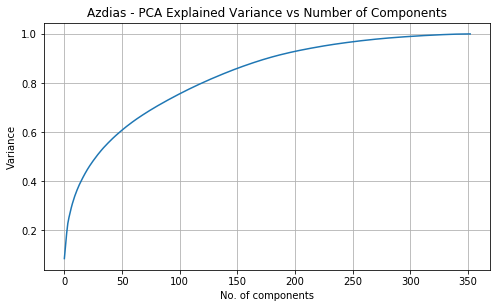

In [15]:
plot_pca_variance(pca_azdias)

From the graph above, we can see that approximately 175 components explain 90% of the variance. Therefore, we can now proceed with 175 components and analyze which features explain maximum variance.

In [16]:
pca_175, azdias_pca_175 = perform_pca(azdias, n_components=175)

### K MEANS CLUSTERING

Our dataset now contains 175 dimension instead of 353. On this dataset, we can apply K Means clustering algorithm to cluster the data into different segments

In [29]:

SEED =2
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        
        
    return scores, range(K_start, K_end+1, step)

In [30]:

scores, range_ = get_Kmeans_scores(azdias_pca_175, 2, 4, 1)

Performing K-Means clustering
Given range min:2, max:4, step:1

Training for n_clusters:  2
Done! Score:  217693926.416

Training for n_clusters:  3
Done! Score:  209969747.517

Training for n_clusters:  4
Done! Score:  205424860.092


In [31]:

def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

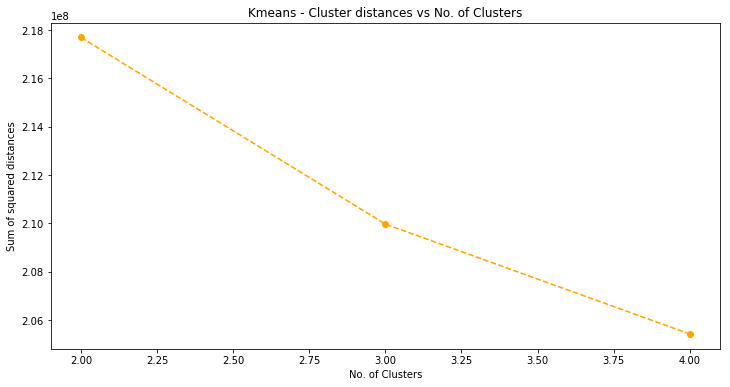

In [32]:
plot_elbow(scores, range_)

**Choosing the right value for K**
We need to choose an appropriate value for K, in which the points inside the cluster are as close as possible and the clusters are farthest away from other clusters. Using the elbow method, we can choose a value for K. It shows that by adding another cluster, the intra cluster variation does not increase. Thus,we look at the value of K in the graph above where the curve flattens. Since the curve starts to flatten at 4, we pick k=4

In [33]:
kmeans = KMeans(4, random_state=SEED)

kmeans.fit(azdias_pca_175)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

In [34]:
azdias_clusters = kmeans.predict(azdias_pca_175)

In [36]:
customers_pca_175 = pca_175.transform(customers)

In [37]:
customers_clusters = kmeans.predict(customers_pca_175)

**Distribution of people in clusters**

In [40]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [42]:
cluster_info

,Cluster,Population,Customers
0,0,99383,7089
1,1,177615,54666
2,2,244680,58996
3,3,215610,13495


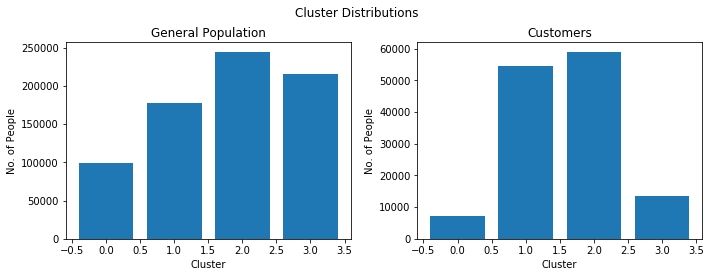

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [44]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
mailout_train.shape

(42962, 367)

0    42430
1      532
Name: RESPONSE, dtype: int64


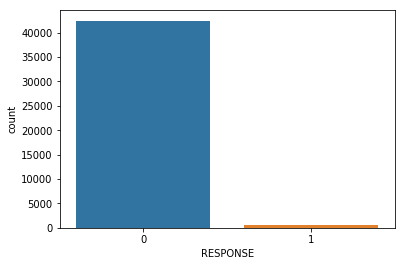

In [51]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

### EVALUATION METRIC

Since the data is very sparse for class 1, using accuracy as the evluation metric would not be ideal. Even if all the classes are predicted as 0, we would have a high accuracy. Usual metrics to handle these kind of cases are Precision, Recall and Area Under Receiver Operating Curve. A confusion matrix needs to be plotted in order to calculate these metrics. Using the confusion matrix, we can obtain the True positives, True Negatives, False Positives and False Negatives.

Then we can calculate Precision and Recall using below formulae:
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)

Before we proceed with implementing the supervised model, we need to apply all the data cleaning steps to the training data as well.

In [118]:
def clean_data_for_supervised(cleaned_azdias, df, attributes_values):
    
    print("Cleaning Given Dataframe")
    
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
    
    print(df[warning_cols[0]].dtype)
    print(df[warning_cols[1]].dtype)
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = resolve_issue_cols(df)
        
        
    print("\tFixing LP_* columns")
    df = resolve_LP_cols(df)
    
    print("\tFixing EINGEFUGT column")
    df = fix_eigefugt_col(df)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unknown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    
    df = replace_unknowns(df, unknown_attributes_values, verbose=False)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding columns")
    df = feature_encoding(df)

   
    
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    cols_to_drop = [col for col in df.columns if col not in azdias.columns]
#     cols_to_drop += ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
    
    df = remove_columns(df, cols_to_drop)
    
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = Imputer(strategy="most_frequent")
    
    imputer.fit(azdias)
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)
    
    
    
    return df

In [119]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [120]:
def resolve_issue_cols(df):
    """
    Function to replace 'X' and 'XX' with nan values  in the issue columns
    """
   
    issue_cols = list(df.columns[18:20])
   
    df[issue_cols] = df[issue_cols].replace({"X":np.nan,"XX":np.nan})
   
    df[issue_cols] = df[issue_cols].astype(float)
    
    return df

In [121]:
mailout_train = clean_data_for_supervised(azdias, mailout_train, attribute_values)

Cleaning Given Dataframe
	Fixing 18, 19 columns
float64
float64
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding columns
	Dropping extra columns
	Imputing missing values with most frequent ones


In [122]:
mailout_train.shape

(42962, 353)

### BENCHMARK MODEL

We train Logistic Regression model as base model to benchmark our performance. We'll focus to improve on this performance

In [129]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [130]:
lr = LogisticRegression(random_state=SEED)

In [131]:

lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [133]:
pred = lr.predict_proba(X_val)[:,1]

In [134]:
pred

array([ 0.0545928 ,  0.01052904,  0.00456711, ...,  0.00747932,
        0.01105694,  0.01006093])

In [135]:

print("Baseline AUROC - ", roc_auc_score(y_val, pred))

Baseline AUROC -  0.66841517882


Thus the baseline we have achieved for our model with logistic regression is 0.66

### DIFFERENT TRAINING MODELS TO IMPROVE PERFORMANCE

In [138]:
#SCALING DATA
scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

In [139]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [140]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed

In [146]:

models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED))]

In [147]:

results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

In [148]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.63755,15.4949
1,DecisionTreeClassifier,0.505844,3.86478
2,RandomForestClassifier,0.520578,1.56777
3,GradientBoostingClassifier,0.742469,44.8501
4,AdaBoostClassifier,0.715393,16.4711


As seen above both Gradient Boosting classifier and Adaboost classifieres worked well for our data. However, Adaboost performed mich better considering the time it took to train the model. Thus we will proceed with AdaBoost for training our model and hyperparameter tuning.

### ADABOOST CLASSIFIER

In [153]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [154]:

%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  12.6s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  12.6s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  12.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  12.6s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  12.5s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=  25.2s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=  25.4s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=  25.1s
[CV] algorithm=SAMME.R, learning_rate=0

[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=200, total=  50.2s
[CV] algorithm=SAMME.R, learning_rate=0.5, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=200, total=  50.8s
[CV] algorithm=SAMME.R, learning_rate=0.5, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=200, total=  50.3s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=50 ...........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=50, total=  12.7s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=50 ...........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=50, total=  12.6s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=50 ...........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=50, total=  12.6s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=50 ...........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=50, total=  12.6s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_e

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 54.1min finished


Best Score:  0.772236301334
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
CPU times: user 54min 23s, sys: 0 ns, total: 54min 23s
Wall time: 54min 38s


In [155]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7431


In [156]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})')

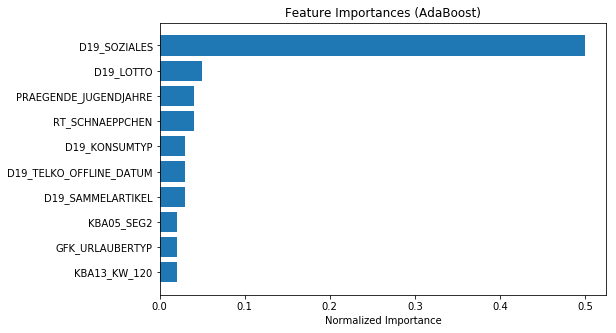

In [157]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=mailout_train.columns)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [158]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [161]:
#CLEANING THE DATA
mailout_test_LNR = mailout_test["LNR"]
mailout_test = clean_data_for_supervised(azdias, mailout_test, attribute_values)
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)

Cleaning Given Dataframe
	Fixing 18, 19 columns
object
object
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding columns
	Dropping extra columns
	Imputing missing values with most frequent ones


In [162]:
best_adaboost.fit(mailout_train, labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=2)

In [163]:

preds_test_adaboost = best_adaboost.predict_proba(mailout_test)[:,1]

In [164]:
kaggle_adaboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [165]:
kaggle_adaboost.head()

,RESPONSE
LNR,
1754,0.416992
1770,0.415570
1465,0.367416
1470,0.369009
1478,0.369548


In [ ]:
kaggle_adaboost.to_csv("./Submissions/submission1.csv")